# Transformer
[Transformer 详解](https://wmathor.com/index.php/archives/1438/)

## 0模型研究

### 0.1 Transformer计算图（未看教程，个人理解，不一定全对）

**Transformer全流程图**
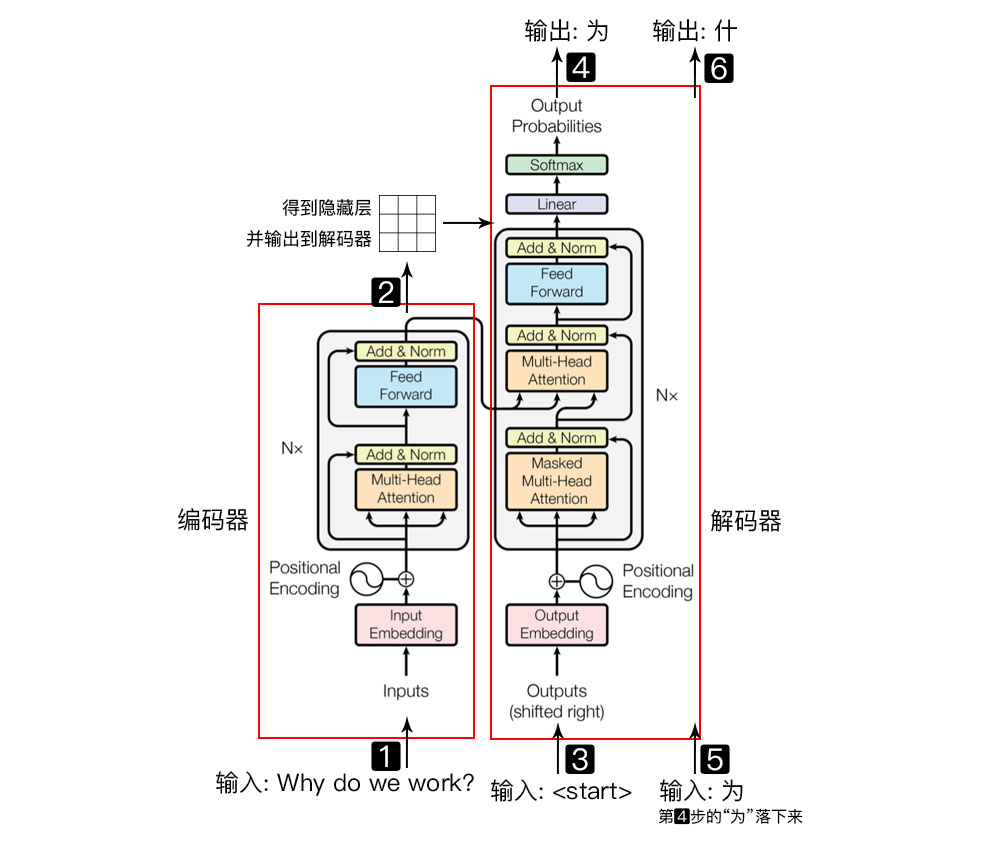
**自注意力机制**
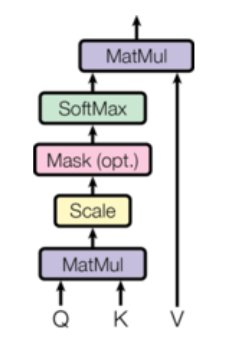

1. 词向量处理
    + 作用：将文本句子向量化
    + 输入：一组组句子（有问有答，分别用于Encoder和Decoder部分,模型训练好后实际使用时，应答部分的初始化结果为占位用的空字符向量）
    + 输出：一组组句子向量（问/答，分别用于Encoder和Decoder部分）
2. Embedding
    + 作用：将一维词向量转换成二维的词矩阵
    + 输入：一组组句子向量（问/答）
    + 输出：一组组句子矩阵（问/答）（矩阵的每一行都是一个词向量）
3. Postitional Encoding
    + 作用：为句子矩阵中的各个词添加位置信息
    + 输入：一组组句子矩阵（问/答）
    + 输出：添加了位置信息的句子矩阵（问/答）
4. Multi-Head Attention
    + 作用：多头注意力模型训练句子矩阵，主要内容有多头机制、QKV计算、打分机制
    + 输入：一组组的句子矩阵（问/答）
    + 输出：一组组的句子矩阵（问/答）
5. 多头机制
    + 作用：使用多个Head Attention给句子打分，并纵向拼接，使用一个独特的算法将分数合并，个人认为类型随机森林这类投票机制
    + 输入：一组组的句子矩阵（问/答）
    + 输出：一组组的句子矩阵的分数（问/答）
6. QKV计算
    + 作用：QKV分别为注意力、键、值，是建立的三个超参数，用于拟合输入的词向量
    + 输入：词向量
    + 输出：用于打分的矩阵
7. 打分机制
    + 作用：将QKV计算的结果转化成分数，表示当前词之后是某个词的概率
    + 输入：用于打分的矩阵
    + 输出：分数向量
8. Encoder-Decoder Multi-Head Attention    
    + 作用：在Decoder模型中独有的使用Encoder的QK与Decoder的V一起训练的多头注意力模型
    + 输入：一组组的句子矩阵（答）
    + 输出：分数向量（答）
9. Mask Multi-Head Attention    
    + 作用：在Decoder模型中，预测词的时候是一个词一个词预测的，因此要保证预测前面的词的时候不能受到后面的词的影响
    + 输入：一组组的句子矩阵（答）
    + 输出：分数向量（答）
10. Add & Norm(作用描述不准确，输入输出不确定)
    + 作用：将多头的计算结果加权求和并归一化，输出为真正的分数，再与原句配对，形成句中每个词之后跟某个词的概率矩阵（不一定准确）
    + 输入：分数向量矩阵
    + 输出：词/分数向量矩阵
11. Feed Forward
    + 作用：前向反馈
    + 输入：句子矩阵
    + 输出：句子矩阵
12. Linear（不准确）
    + 作用：线性层，将模型拟合结果转化成句子概率矩阵
    + 输入：
    + 输出：
13. softmax
    + 作用：将结果转化为词概率
    + 输入：
    + 输出：
    
模型增强：
+ Dropout：随机消除模型训练过程中的部分向量的部分位，增强模型的泛化能力

模型技术：
+ mask（掩码技术）：因为句子长度不同需要按照最长句子补全，因此需要使用掩码消除补全部分对模型结果的影响，即：让补全的部分不参与运算

### 0.2 Positional Encoding

[https://wmathor.com/index.php/archives/1453/](https://wmathor.com/index.php/archives/1453/)

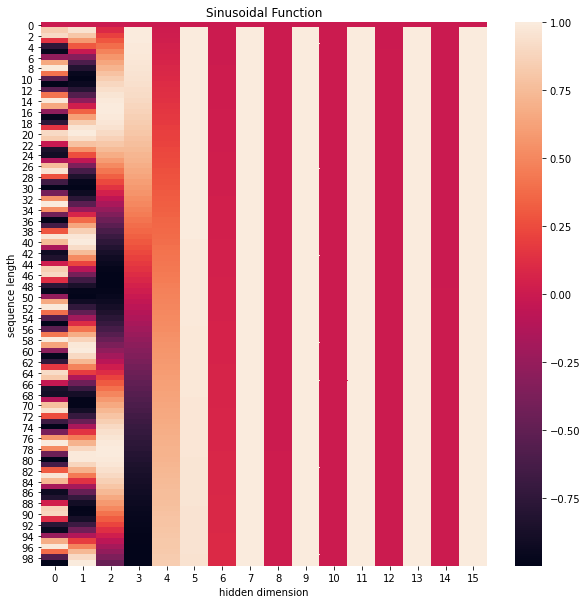

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def get_positional_encoding(max_seq_len, embed_dim):
    # 初始化一个positional encoding
    # embed_dim: 字嵌入的维度
    # max_seq_len: 最大的序列长度
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i 偶数
    positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1 奇数
    # print(positional_encoding)
    return positional_encoding

positional_encoding = get_positional_encoding(max_seq_len=100, embed_dim=16)
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length");

Text(0, 0.5, 'Period of Positional Encoding')

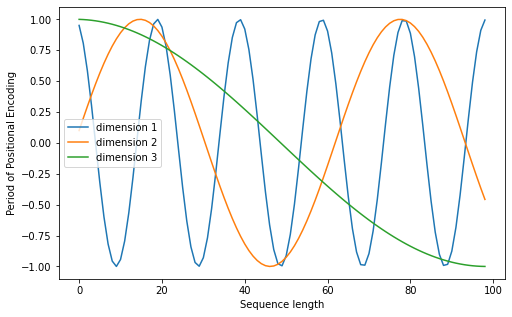

In [2]:
plt.figure(figsize=(8, 5))
plt.plot(positional_encoding[1:, 1], label="dimension 1")
plt.plot(positional_encoding[1:, 2], label="dimension 2")
plt.plot(positional_encoding[1:, 3], label="dimension 3")
plt.legend()
plt.xlabel("Sequence length")
plt.ylabel("Period of Positional Encoding")

In [3]:
import torch
import numpy as np

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


mask = subsequent_mask(3)
print(mask)
mask.unsqueeze(1)

tensor([[[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]])


tensor([[[[ True, False, False],
          [ True,  True, False],
          [ True,  True,  True]]]])

### 0.3 数据结构

- 第一维：一批句子：模型训练时传入数据是分批次的，一批中包含多个句子，应该是为了充分利用计算资源，进行并发计算，因此第一个维度一批数据中的代表一个个的句子。
- 第二维：句子向量：一个句子会被拆分成一个个词做成句子向量。
- 第三维：词向量：数据经过嵌入层（Embedding）时，会被增加维度，相当于将每个词做成了词向量，词向量长度在当前模型中即为d_model参数。

## 1 模型复现

+ Linear & Softmax
    + class Generator(nn.Module)
+ N_layer Encoder & N_layer Decoder
    + class EncoderDecoder(nn.Module)
+ Encoder & Decoder
    + def clones(module, N)  # 模型克隆
    + class Encoder(nn.Module)
    + class Decoder(nn.Module)
+ sub Encoder & sub Decoder
    + class EncoderLayer(nn.Module)
    + class DecoderLayer(nn.Module)
+ mask
    + def subsequent_mask(size)
+ add & Norm
    + class LayerNorm(nn.Module)
    + class SublayerConnection(nn.Module)  # 子层连接层
+ Multi-Head Attention
    + class MultiHeadedAttention(nn.Module)
+ attention
    + def attention(query, key, value, mask=None, dropout=None)
+ Feed Forward
    + class PositionwiseFeedForward(nn.Module)
+ embedding
    + class Embeddings(nn.Module)
+ positional（位置编码）
    + class PositionalEncoding(nn.Module)
+ 数据预处理
    + class Voc()
+ 完整模型
    + def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1)
+ 模型训练
    + class Batch
    + def run_epoch(data_iter, model, loss_compute)
    + def batch_size_fn(new, count, sofar)  # 批处理（没看懂）
    + class NoamOpt  # 优化器
    + class LabelSmoothing(nn.Module)  # 正则化
    + class MultiGPULossCompute  # 多GPU
    + def draw(data, x, y, ax)  # 注意力可视化

### 1.1 加载包

In [4]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

### 1.2 Linear & Softmax

In [5]:
class Generator(nn.Module):
    """线性层与softmax层"""

    def __init__(self, d_model, vocab):
        """
        :param d_model: 模型一维长度，一般为512，方便多头计算
        :param vocab: 词典中的词数量
        """
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        """
        max(a*x+b),将Transformer的输出转换成概率词出现的概率
        :param x: decoder生成的Transformer的输出，size(d_model, N)
        :return:
        """
        return F.log_softmax(self.proj(x), dim=-1)

### 1.3 编码器与解码器结构

In [6]:
class EncoderDecoder(nn.Module):
    """一个标准的编码器-解码器架构。这是很多其他模型的基础。"""
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        """
        :param encoder: 编码器模型
        :param decoder: 解码器模型
        :param src_embed: 输入端嵌入层模型
        :param tgt_embed: 输出端嵌入层模型
        :param generator: Generator, 线性层与softmax层
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        :param src: 句子向量，输入文本
        :param tgt: 句子向量，输出文本
        :param src_mask: 输入文本的掩码
        :param tgt_mask: 输出文本的掩码
        :return:
        """
        return self.decode(self.encode(src, src_mask), 
                           src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        :param memory: 当前Transformer模型中即为self.encode的输出，seq2seq中可能还会再加入注意力模型等
        :param src_mask:
        :param tgt:
        :param tgt_mask:
        :return:
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

### 1.4 标准化与子层连接
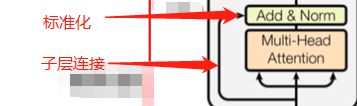

In [7]:
class LayerNorm(nn.Module):
    """层标准化，add & Norm
    公式：a * (x-mean_x) / (std_x + eps) + b
    引入超参数a和b，向量长度与特征数量相同
    """
    def __init__(self, features, eps=1e-6):
        """
        :param features: 特征数量
        :param eps: 为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x: torch.Tensor):
        """
        :param x: 嵌入后的句子矩阵，三个维度，逐个句子>逐个词>嵌入后的词矩阵
        :return:
        """
        # 由于是对嵌入后的句子矩阵进行计算，因此实际是对句子矩阵中的每个词矩阵计算，
        # 因此要选择句子对应的维度后再计算
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [8]:
class SubLayerConnection(nn.Module):
    """在层规范之后的残差连接。
    注意，为了代码的简单性，规范是第一个，而不是最后一个。
    包含标准化模型
    """
    def __init__(self, size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """将剩余连接应用到相同大小的任何子层。"""
        return x + self.dropout(sublayer(self.norm(x)))

### 1.5 编码器

In [9]:
def clones(module, N):
    """模型克隆"""
    # 产生N个相同的层，N=6
    # ModuleList 可以像常规Python列表一样编制索引，包含的模块已正确注册
    # copy.copy 浅拷贝 只拷贝父对象，不会拷贝对象的内部的子对象
    # copy.deepcopy 深拷贝 拷贝对象及其子对象
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [10]:
class Encoder(nn.Module):
    """编码器模型，内部包含多层编码器"""
    def __init__(self, layer, N):
        """
        :param layer: 编码器
        :param N: 编码器层数
        """
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        # 归一化层 LayerNorm(normalized_shape, eps=1e-05, elementwise_affine=True)
        # normalized_shape 输入尺寸  [∗×normalized_shape[0]×normalized_shape[1]×…×normalized_shape[−1]]
        # eps-为保证数值稳定性（分母不能趋近或取0）,给分母加上的值。默认为1e-5
        # elementwise_affine 布尔值，当设为true，给该层添加可学习的仿射变换参数
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [11]:
class EncoderLayer(nn.Module):
    """编码器的一层模型，执行顺序为：多头注意力模型>子层连接>前向反馈>子层连接"""
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### 1.6 解码器

In [12]:
class Decoder(nn.Module):
    """解码器，解码器中forward方法需要传入Decoder的输出"""
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        :param x: 预测结果
        :param memory: Encoder输出
        :param src_mask: Encoder mask
        :param tgt_mask: 预测结果 mask
        :return: 
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [13]:
class DecoderLayer(nn.Module):
    """解码器的一层模型，
    执行顺序为：自注意力>子层连接>Encoder-Decoder注意力>子层连接>前向反馈>子层连接"""
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [14]:
def subsequent_mask(size):
    """连续掩码，一个上半区为False,下半区为True的维度为(size,size)的矩阵"""
    attn_shape = (1, size, size)
    mask = np.triu(torch.ones(attn_shape), k=1).astype("uint8")
    return torch.from_numpy(mask) == 0

# subsequent_mask(4)

### 1.7 注意力算法
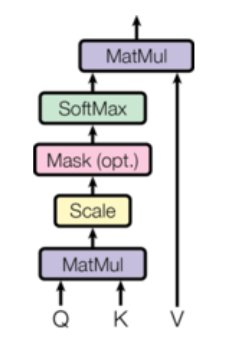

In [15]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask=None, dropout=None):
    """注意力算法: softmax(Q * K_t / sqrt(d_k)) * V
    K_t是K的转置；d_k是Q的size(-1);
    :param query: 注意力矩阵，三维矩阵
    :param key: 三维矩阵
    :param value: 三维矩阵
    :param mask: 掩码，在softmax前使用
    :param dropout: 在softmax后，乘value前使用，随机去除一些值
    :return: 
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

**多头注意力模型**

**多头的真相**：多头就是将原本长度为`d_model`(一般是512)的向量拆成`h`个长度为`d_k`的的向量，再分别计算注意力，再合并成长度为`d_model`的向量.

下面代码中的self.h就是多头的头的数量，self.d_k是拆分后的向量长度，nbatches是当前批次有多少句子。

```python
query, key, value = [
    l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) 
    for l, x in zip(self.linears, (query, key, value))
]
```
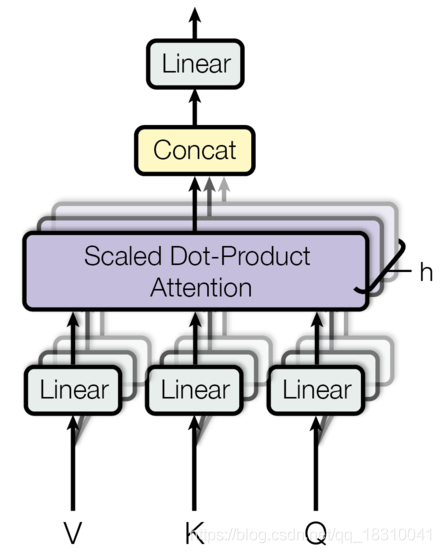

In [16]:
class MultiHeadedAttention(nn.Module):
    """多头注意力模型
    执行顺序：Q/K/V>Linear/Linear/Linear>attention>concat>Linear
    """
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 同样的掩码适用于所有的h头
            # 添加一个维度
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # QKV分别进入线性层，并改变维度
        # zip会根据少的数组确定结果长度
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        # 添加到注意力算法中计算
        x, self.attn = attention(query, key, value, mask)
        # 维度合并（concat）
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 1.8 注意力算法在模型中的应用
Transformer中以三种不同的方式使用了“多头”Attention：
1. 在"Encoder-Decoder Attention"层，Query来自先前的解码器层，并且Key和Value来自Encoder的输出。Decoder中的每个位置Attend输入序列中的所有位置，这与Seq2Seq模型中的经典的Encoder-Decoder Attention机制一致。
2. Encoder中的Self-attention层。在Self-attention层中，所有的Key、Value和Query都来同一个地方，这里都是来自Encoder中前一层的输出。Encoder中当前层的每个位置都能Attend到前一层的所有位置。
3. 类似的，解码器中的Self-attention层允许解码器中的每个位置Attend当前解码位置和它前面的所有位置。这里需要屏蔽解码器中向左的信息流以保持自回归属性。具体的实现方式是在缩放后的点积Attention中，屏蔽（设为−∞）Softmax的输入中所有对应着非法连接的Value。

### 1.9 Position-wise前馈网络
$$FFN(x)=max(0, xW_1+b_1)W_2+b_2$$

In [17]:
class PositionwiseFeedForward(nn.Module):
    """Positionwise前馈神经网络
    FFN = max(0, x*w_1+b_1)*w_2 + b_2
    执行过程：linear>relu>dropout>linear
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### 1.10 Embedding和Softmax
使用预学习的Embedding将输入Token序列和输出Token序列转化为$d_{model}$维向量。使用常用的预训练的线性变换和Softmax函数将解码器输出转换为预测下一个Token的概率。在我们的模型中，我们在两个Embedding层和Pre-softmax线性变换之间共享相同的权重矩阵。在Embedding层中，我们将这些权重乘以$\sqrt{d_{model}}$。

In [18]:
class Embeddings(nn.Module):
    """
    使用预学习的Embedding将输入Token序列和输出Token序列
    转化为d_model维向量
    """
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [19]:
# 测试
# lut = nn.Embedding(10, 4)
# a = torch.arange(4)
# lut(a), lut(a) * math.sqrt(4)

### 1.11 位置编码
由于本模型不包含递归和卷积结构，为了使模型能够有效利用序列的顺序特征，我们需要加入序列中各个Token间相对位置或Token在序列中绝对位置的信息。在这里，我们将位置编码添加到编码器和解码器栈底部的输入Embedding。由于位置编码与Embedding具有相同的维度dmodeldmodel，因此两者可以直接相加。使用不同频率的正弦和余弦函数：

$$PE(pos, 2i) = sin(pos/10000^{2i/d_{model}})$$
$$PE(pos, 2i+1) = cos(pos/10000^{2i/d_{model}})$$

其中$pos$是位置，$i$是维度。 也就是说，位置编码的每个维度都对应于一个正弦曲线，其波长形成从$2\pi$到$10000\cdot 2\pi$的等比级数。我们之所以选择了这个函数，是因为我们假设它能让模型很容易学会Attend相对位置，因为对于任何固定的偏移量$k$，$PE_{pos+k}$可以表示为$PE_{pos}$的线性函数。

此外，在编码器和解码器堆栈中，我们在Embedding与位置编码的加和上都使用了Dropout机制。在基本模型上，我们使用$P_{drop}=0.1$的比率。

In [20]:
# # 测试：模型中的各个计算的意义
# from IPython.display import display

# vocab, d_model = 10, 5
# lut = nn.Embedding(vocab, d_model)
# x = lut(torch.arange(4))
# display(x)
# display(x.size())

# max_len = 5000
# pe = torch.ones(max_len, d_model)
# pe = pe.unsqueeze(0)
# position = torch.arange(0, max_len).unsqueeze(1)
# display(pe)
# display(pe.size(), position.size())
# display(pe[:, :x.size(1)].size())

In [21]:
class PositionalEncoding(nn.Module):
    """位置编码
    PE(pos, 2i) = sin(pos/10000^{2i/d_{model}})
    PE(pos, 2i+1) = cos(pos/10000^{2i/d_{model}})
    """
    def __init__(self, d_model, dropout, max_len=5000):
        """
        :param d_model:
        :param dropout:
        :param max_len: 默认为5000，准备了足够多的位置编码供模型使用
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # positional_encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

In [22]:
# # 测试：位置信息是添加到了每一个向量中的每一个元素中的
# # 而非添加在向量的最后
# # 注意x和pe的维度，
# # 第一维是空出来的句子维，应该是训练多个句子时使用的吧
# # 也可能是表示多头注意力时用多种方式表示当前向量时要用的（几率更大）
# x = torch.arange(20).view((1, 5, 4))
# pe = torch.arange(40).view((1, 10, 4))
# x2 = x + pe[:, :x.size(1)]
# print(x2)
# print(x2.size())

In [23]:
# # 测试；模型正常
# d_model = 8  # 8/64/128/256/512(实际一般用512)
# vocab = 2000
# emb = Embeddings(d_model, vocab)
# pe = PositionalEncoding(d_model, 0.1)
# print(pe.pe.size())
# x = emb(torch.arange(10).unsqueeze(0))
# print(x.size(), x.size(1))
# # print(x)
# x = pe(x)
# print(x.size())
# # print(x)

#### 位置编码图示

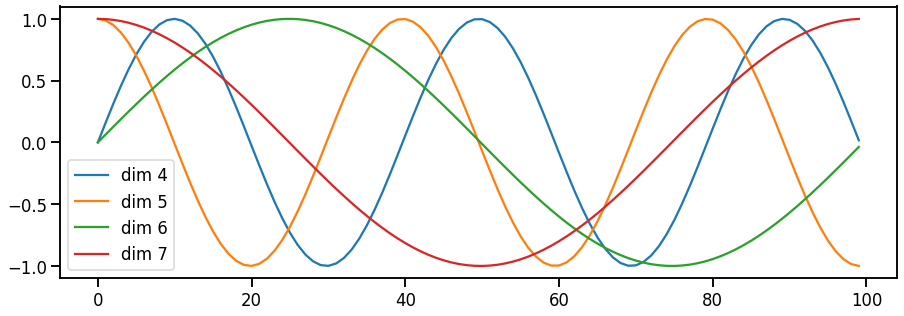

In [24]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]]);

### 1.12 完整模型

In [25]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """连接完整模型并设置超参的函数
    :param src_vocab: 输入词的词典大小（词数量）
    :param tgt_vocab: 目标词的词典大小（词数量）
    :param N: 模型层数，默认6层，可以根据计算能力与需求修改
    :param d_model: 模型嵌入时向量长度，一般设置为512，方便存储和计算
    :param d_ff: ff为Feed Forward，该参数即为正向传播的向量长度
    :param h: 多头注意力的头的数量，一般为8
    :param dropout: nn.Dropout的参数，默认是0.1，随机清理10%的数据
    :return:
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)  # 教程中未设置dropout参数
    ff = PositionwiseFeedForward(d_model, d_ff, dropout=dropout)
    position = PositionalEncoding(d_model, dropout)

    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout=dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout=dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )

    # 这一点在代码中很重要。
    # 使用Glorot / fan_avg初始化参数。
    for p in model.parameters():
        if p.dim() > 1:
            # nn.init.xavier_uniform(p)  # 旧
            nn.init.xavier_uniform_(p)  # 新
    return model

In [26]:
# # 测试
# tmp_model = make_model(10, 10, 2)
# tmp_model.src_embed[0].d_model

## 2 模型训练

>快速穿插介绍训练标准编码器解码器模型需要的一些工具。首先我们定义一个包含源和目标句子的批训练对象用于训练，同时构造掩码。

### 2.1 批和掩码

In [27]:
class Batch:
    """用于在训练过程中保存带掩码的一批数据的对象"""
    def __init__(self, src, trg=None, pad=0):
        """
        :param src: 输入的句子向量
        :param trg: 对应的输出
        :param pad: 用于将句子填充到最长句的句长的填充物
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]  # 去除结束符
            self.trg_y = trg[:, 1:]  # 去除起始符
            # 掩码
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # 句子长度
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """
        创建一个掩码来隐藏填充中和未填充的单词
        由于句子的长度不同，短句需要用pad填充，在为其创建mask时需要将填充部分全部排除在外，
        :param tgt: 目标向量
        :param pad: 填充物，非句子内容，用于补全句子长度的参数
        :return: 
        """
        # 将目标向量转换成bool向量，表示当前位置是否有词，并添加维度
        tgt_mask = (tgt != pad).unsqueeze(-2)
        # 再与创建的mask做与操作，创建出正确的mask
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

接下来，创建一个通用的训练和得分函数来跟踪损失。传入一个通用的损失计算函数，它也处理参数更新。

### 2.2 训练循环

In [28]:
def run_epoch(data_iter, model, loss_compute):
    """
    标准的训练和跟踪功能
    :param data_iter: 待处理数据，[Batch(), Batch(), ...]
    :param model: 用于训练的模型
    :param loss_compute: 损失函数模型
    :return:
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg,
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                  (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

### 2.3 训练数据和批处理
我们使用标准WMT 2014英语-德语数据集进行了训练，该数据集包含大约450万个句子对。 使用字节对的编码方法对句子进行编码，该编码具有大约37000个词的共享源-目标词汇表。 对于英语-法语，我们使用了WMT 2014 英语-法语数据集，该数据集由36M个句子组成，并将词分成32000个词片(Word-piece)的词汇表。

句子对按照近似的序列长度进行批处理。每个训练批包含一组句子对，包含大约25000个源词和25000个目标词。

> 我们将使用torch text来创建批次。下面更详细地讨论实现过程。 我们在torchtext的一个函数中创建批次，确保填充到最大批训练长度的大小不超过阈值（如果我们有8个GPU，则阈值为25000）。

In [29]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    """继续扩充batch并计算令牌+填充的总数。"""
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_src_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

### 2.4 硬件和训练进度
　　我们在一台配备8个NVIDIA P100 GPU的机器上训练我们的模型。 对于使用本文所述的超参数的基本模型，每个训练单步大约需要0.4秒。 我们对基础模型进行了总共100,000步或12小时的训练。 对于我们的大型模型，每个训练单步时间为1.0秒。 大型模型通常需要训练300,000步（3.5天）。

### 2.5 优化器
我们选择[Adam](https://arxiv.org/abs/1412.6980)作为优化器，其参数为$β_1=0.9$、$β_2=0.98$和$ϵ=10^{−9}$。根据以下公式，我们在训练过程中改变了学习率：$lrate=d^{−0.5}_{model}⋅min(step\_num^{−0.5},step_num⋅warmup\_steps^{−1.5})$。在预热中随步数线性地增加学习速率，并且此后与步数的反平方根成比例地减小它。我们设置预热步数为4000。

> 注意：这部分非常重要，需要这种设置训练模型。

In [30]:
class NoamOpt:
    """Optim wrapper that implements rate.
    创建一个智能调整学习速率的优化器，
    在前期模型预热阶段速率越来越大，后面逐渐减小
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        """
        :param model_size: 前面模型中的d_model参数，模型参数维度
        :param factor: 系数，学习速率系数
        :param warmup: 预热
        :param optimizer: 优化器
        """
        self.model_size = model_size
        self.factor = factor
        self.warmup = warmup
        self.optimizer = optimizer
        self._step = 0
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            # 修改学习速率
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """学习速率（lr）"""
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) *
                              min(step**(-0.5), step * self.warmup**(-1.5)))


def get_std_opt(model):
    opt = torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.8), eps=1e-9)
    return NoamOpt(model.src_embed[0].d_model, 2, 4000, optimizer=opt)

当前模型在不同模型大小和超参数的情况下的曲线示例。 

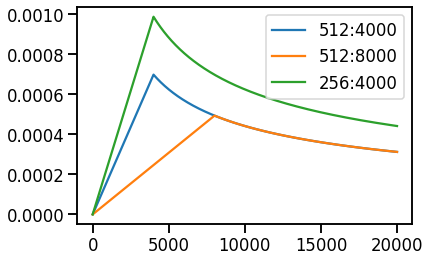

In [31]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"]);

### 2.6 正则化
#### 2.6.1 标签平滑
<font color="red">有了解，这里未做详细研究</font>

在训练期间，我们采用了值$ϵls=0.1$的标签平滑。 这种做法提高了困惑度，因为模型变得更加不确定，但提高了准确性和BLEU分数。

> 我们使用KL div loss实现标签平滑。 相比使用独热目标分布，我们创建一个分布，其包含正确单词的置信度和整个词汇表中分布的其余平滑项。

In [32]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        # size_average=False 改为 reduction="sum"
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:18: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)


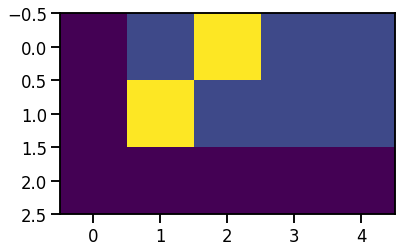

In [33]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(
    Variable(predict.log()), 
    Variable(torch.LongTensor([2, 1, 0]))
)

plt.imshow(crit.true_dist);

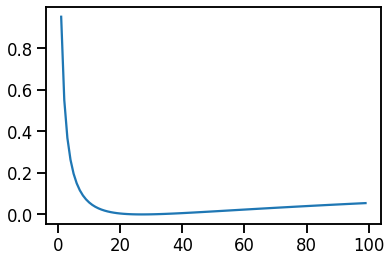

In [34]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],])
    # print(predict)
    return crit(
        Variable(predict.log()), 
        Variable(torch.LongTensor([1]))
    ).item()
    # .data[0] 新版中国改为 .item()


plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)]);

## 3 第一个例子

> 我们可以先尝试一个简单的复制任务。 给定来自小词汇表的随机输入符号集，目标是生成那些相同的符号。

### 3.1 数据生成

In [35]:
def data_gen(V, batch, nbatches):
    """
    为src-tgt复制任务生成随机数据
    :param V: 生成的数据最大值，相当于词典大小
    :param batch: 批次大小，一批数据中有多少句话
    :param nbatches: 数据量
    :return:
    """
    for i in range(nbatches):
        # 从1开始，因为0是起始符
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))).long()
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [36]:
# # 测试
# for i in data_gen(200, 10, 1):
#     print(i)
#     print(i.src.size())
#     print(i.trg.size())    

### 3.2 损失计算

In [37]:
class SimpleLossCompute(object):
    """一个简单的损失计算和训练函数"""
    def __init__(self, generator, criterion, opt=None):
        """
        :param generator: Generator, 线性层与softmax层
        :param criterion: 损失函数
        :param opt: 优化器
        """
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

### 3.3 贪心解码

In [38]:
# 训练一个简单的拷贝任务
if True:
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)
    model_opt = NoamOpt(
        model.src_embed[0].d_model, 1, 400, 
        torch.optim.Adam(
            model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9
        ))

    for epoch in range(10):
        model.train()
        run_epoch(data_gen(V, 30, 20), model, 
                  SimpleLossCompute(model.generator, criterion, model_opt))
        model.eval()
        print(run_epoch(data_gen(V, 30, 5), model, 
                        SimpleLossCompute(model.generator, criterion, None)))

Epoch Step: 1 Loss: 3.067974 Tokens per Sec: 612.788574
Epoch Step: 1 Loss: 1.859628 Tokens per Sec: 1028.130981
tensor(1.8950)
Epoch Step: 1 Loss: 1.925103 Tokens per Sec: 690.099182
Epoch Step: 1 Loss: 1.599241 Tokens per Sec: 985.094421
tensor(1.6024)
Epoch Step: 1 Loss: 1.727219 Tokens per Sec: 720.687073
Epoch Step: 1 Loss: 1.486003 Tokens per Sec: 853.400513
tensor(1.4923)
Epoch Step: 1 Loss: 1.710192 Tokens per Sec: 630.361877
Epoch Step: 1 Loss: 1.185291 Tokens per Sec: 713.689026
tensor(1.2841)
Epoch Step: 1 Loss: 1.313075 Tokens per Sec: 530.833618
Epoch Step: 1 Loss: 0.932432 Tokens per Sec: 875.146667
tensor(0.9481)
Epoch Step: 1 Loss: 1.005755 Tokens per Sec: 636.530579
Epoch Step: 1 Loss: 0.587088 Tokens per Sec: 890.637146
tensor(0.6066)
Epoch Step: 1 Loss: 0.891096 Tokens per Sec: 624.897827
Epoch Step: 1 Loss: 0.379206 Tokens per Sec: 886.087646
tensor(0.4315)
Epoch Step: 1 Loss: 0.644551 Tokens per Sec: 616.359924
Epoch Step: 1 Loss: 0.555197 Tokens per Sec: 878.34057

In [39]:
def greedy_decode(model: EncoderDecoder, src, src_mask, max_len, start_symbol):
    """ 贪心解码
    执行流程：
        用起始符构建结果向量初始状态；
        src通过encode模型，生成编码器结果，该结果会一直在解码器中使用；
        循环解码：（循环次数为最大句子长度-1，因为起始符占用一位）
            结果向量通过decode模型（会用到encode的结果）；
            输出结果通过generator，变成各个词的概率值；
            使用贪心算法获取最佳结果，将结果最佳到结果向量中；
        输出结果向量。
    :param model: 模型
    :param src: 输入数据
    :param src_mask: 输入数据掩码
    :param max_len: 最大长度
    :param start_symbol: 起始符
    :return:
    """
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask,
                     Variable(ys),
                     Variable(subsequent_mask(ys.size(1)).type_as(src_mask)))
        # 最后一位是结束符
        prob = model.generator(out[:, -1])
        # 贪心算法，仅看中每个位置上权重最大的值
        # 此外还可以取前N个权重较大的值，全部带入后续训练，
        # 在后续训练中也同样保留N个权重最大的，最终选择选出一个最优解
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # 一个词一个词预测的，预测结果添加到输出中，再放入模型继续预测下一个词。
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src).fill_(next_word)], dim=1)
    return ys

## 4 真实示例

现在我们通过IWSLT德语-英语翻译任务介绍一个真实示例。 该任务比上文提及的WMT任务小得多，但它说明了整个系统。 我们还展示了如何使用多个GPU处理加速其训练。

**下载数据**
```python
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de 
```
下载数据时提示服务器连接不上，可以使用该博客中的地址下载数据,第一个博客中给出的`en_core_web_sm`地址是老版本的，可以用第二个链接中的地址
- [python -m spacy download en 提示服务器连接一直失败安装不上](https://blog.csdn.net/wzy31014332886/article/details/104605887)
- [NLP Spacy中en_core_web_sm安装问题，及最新版下载地址](https://blog.csdn.net/qq_42426451/article/details/113126194)

下载链接：
- 英语：en_core_web_sm-2.2.5：[网盘下载](https://pan.baidu.com/s/1D6fc7O9IK0v0jS9j5zqTcw) 提取码：jnmw
- 英语：en_core_web_sm-2.3.0：[下载链接](https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.0/en_core_web_sm-2.3.0.tar.gz)
- 德语：de_core_news_sm-2.3.0：[网盘下载](https://pan.baidu.com/s/1e4jnbyrkQEPaqrBZDQKKFA) 提取码：3hbz
- 中文：zh_core_web_sm-2.3.0：[下载链接](https://github.com/explosion/spacy-models/releases/download/zh_core_web_sm-2.3.0/zh_core_web_sm-2.3.0.tar.gz)

注：修改下面链接中的XXX为需要的数据模型，修改YYY为需要的版本号可以下载任意数据模型：
- https://github.com/explosion/spacy-models/releases/tag/XXX-YYY

### 4.1 数据加载

使用torchtext和spacy加载数据集以进行词语切分。

数据离线下载地址
- https://wit3.fbk.eu/archive/2016-01//texts/de/en/de-en.tgz

In [40]:
from torchtext import data, datasets


if True:
    import spacy

    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')
    # print(spacy_de.__dict__)

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = "<s>"  # 句子起始符
    EOS_WORD = "</s>"  # 句子结束符
    BLACK_WORD = "<blank>"  # 句子填充符（将句子补全成相同长度）
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLACK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token=BOS_WORD,
                     eos_token=EOS_WORD, pad_token=BLACK_WORD)

    MAX_LEN = 100  # 最大句子长度
    # 注意此处加载了de-en.tgz数据，但需要按指定格式配置路径
    # 由于当前网络未翻墙，因此是离线下载的数据
    # 数据目录结构：.data/iwslt/de-en
    # root参数配置时配置：.data
    train, val, test = datasets.IWSLT.splits(
        exts=(".de", ".en"), fields=(SRC, TGT),
        root="../../data/英语-德语翻译/.data",
        filter_pred=lambda x: len(vars(x)["src"]) < MAX_LEN and
                              len(vars(x)["trg"]) < MAX_LEN)
    MIN_FREQ = 2  # 最短词长，比这个短的不再作为词使用
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

### 4.2 迭代器

In [41]:
class MyIterator(data.Iterator):
    def create_batches(self):
        """创建数据批次"""
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size, self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))


def rebatch(pad_idx, batch):
    """修正torchtext的顺序以适应我们"""
    src = batch.src.transpose(0, 1)
    trg = batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

### 4.3 多GPU训练

最后为了真正地快速训练，我们将使用多个GPU。 这部分代码实现了多GPU字生成。 它不是Transformer特有的，所以我不会详细介绍。 其思想是将训练时的单词生成分成块，以便在许多不同的GPU上并行处理。 我们使用PyTorch并行原语来做到这一点：

- 复制 - 将模块拆分到不同的GPU上
- 分散 - 将批次拆分到不同的GPU上
- 并行应用 - 在不同GPU上将模块应用于批处理
- 聚集 - 将分散的数据聚集到一个GPU上
- `nn.DataParallel` - 一个特殊的模块包装器，在评估之前调用它们。

In [42]:
class MultiGPULossCompute(object):
    def __init__(self, generator, criterion, devices: list, opt=None, chunk_size=5):
        """
        :param generator: 待并行计算的模型
        :param criterion: 规范化
        :param devices: GPU计算设备，list，例：[0,1,2]
        :param opt: 优化器
        :param chunk_size: 块大小
        """
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator,
                                          devices=self.devices)
        out_scatter = nn.parallel.scatter(out, target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets,
                                      target_gpus=self.devices)

        # 将数据拆分成更小的块，发配到不同的GPU算计算
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # 预测分布
            out_column = [[Variable(o[:, i:i+chunk_size].data,
                                    requires_grad=self.opt is not None)]
                          for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # 计算损失
            y = [(g.contiguous().view(-1, g.size(-1)),
                  t[:, i:i+chunk_size].contiguous().view(-1))
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # sum and normalize loss
            # 在第一个GPU上汇总数据，并求和、标准化loss
            l = nn.parallel.gather(loss, target_device=self.devices[0])
            l = l.sum()[0]/normalize
            total += l.data[0]

            # 输出transformer反向传播loss
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.colone())

        # Backprop all loss through transformer.
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, target_device=self.devices[0])
            
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

现在我们创建模型，损失函数，优化器，数据迭代器和并行化。

In [43]:
# 由于当前设备并无可用的GPU，因此将调用GPU的代码都注释掉了
# devices = [0, 1, 2, 3]
device = None  # GPU时该值为0
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]  # 填充内容编码
    # 构建模型
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    # model.cuda()  # 调用GPU
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx,
                               smoothing=0.1)
    # criterion.cuda()  # 调用GPU
    BATCH_SIZE = 12000
    # 构建训练数据与测试数据，使用train=True/False区分
    # 设置参数包含，数据，批次宽度，设备，是否重复，
    # 排序方式（先根根据src长度排序，再根据结果trg排序）,
    # 计算所有批次的最大宽度的方法，
    # 是否是训练数据
    train_iter = MyIterator(train, batch_size=BATCH_SIZE,
                            device=device, repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE,
                            device=device, repeat=False,
                            sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn,
                            train=False)
    # 并行计算
    # model_par = nn.DataParallel(model, device_ids=devices)

### 4.4 训练系统

> 稍微使用预热步骤，但其他一切都使用默认参数。 在具有4个Tesla V100 GPU的AWS p3.8xlarge机器上，每秒运行约27,000个词，批训练大小大小为12,000。

注：当前设备并没有GPU，上述描述保留下来是为了对GPU计算能力有一个认知。

In [44]:
# # 多GPU并发执行训练模型方式
# is_train = False
# if is_train:
#     model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
#                         torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
#     for epoch in range(10):
#         model_par.train()
#         run_epoch((rebatch(pad_idx, b) for b in train_iter),
#                   model_par,
#                   MultiGPULossCompute(model.generator, criterion,
#                                       devices, opt=model_opt))
#         model_par.eval()
#         loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter),
#                          model_par,
#                          MultiGPULossCompute(model.generator, criterion,
#                                              devices=devices, opt=None))
#         print(loss)
# else:
#     import sys
#     sys.path.append("../PyTorch_Learn_py")
#     from transformer import *
#     model = torch.load("../../data/英语-德语翻译/iwslt.pt", map_location="cpu")

In [45]:
# CPU执行训练模型方式
is_train = False
if is_train:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
                        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter),
                  model,
                  SimpleLossCompute(model.generator, criterion, opt=model_opt))
        model.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter),
                         model,
                         SimpleLossCompute(model.generator, criterion, opt=None))
        print(loss)
else:
    import sys
    sys.path.append("../PyTorch_Learn_py")
    from transformer import *
    # 由于load中访问不到jupyter中的SublayerConnection类（不清楚原因）
    # 因此加载.py版本的模型
    # 由于当前设备没有GPU，因此采用CPU加载模型
    model = torch.load("../../data/英语-德语翻译/iwslt.pt", map_location="cpu")

D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source co

一旦训练完成，我们可以解码模型以产生一组翻译。 在这里，我们只需翻译验证集中的第一个句子。 此数据集非常小，因此使用贪婪搜索的翻译相当准确。

In [46]:
# 贪婪解码，并转换成单词输出
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask,
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": 
            break
        print(sym, end=" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>":
            break
        print(sym, end=" ")
    print()
    break

Translation:	So in thread , they application that life would be weird . 
Target:	So 1860 , they are seeing this dirty technology that is going to choke the life out of New York . 


注：结果不同可能是因为没有使用GPU训练模型，而加载的模型是别人训练好的，导致加载的模型与模型代码并不匹配的原因。

### 4.5 附加组件：BPE，搜索，平均

所以这主要涵盖了Transformer模型本身。 有四个方面我们没有明确涵盖。 我们还实现了所有这些附加功能[OpenNMT-py](https://github.com/opennmt/opennmt-py).

1) 字节对编码/ 字片(Word-piece)：我们可以使用库来首先将数据预处理为子字单元。参见Rico Sennrich的[subword-nmt](https://github.com/rsennrich/subword-nmt)实现。这些模型将训练数据转换为如下所示：
```
▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .
```
2) 共享嵌入：当使用具有共享词汇表的BPE时，我们可以在源/目标/生成器之间共享相同的权重向量，详细见[5]。 要将其添加到模型，只需执行以下操作：

In [47]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

3) 集束搜索：这里展开说有点太复杂了。 PyTorch版本的实现可以参考 [OpenNMT- py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py)。

4) 模型平均：这篇文章平均最后k个检查点以创建一个集合效果。 如果我们有一堆模型，我们可以在事后这样做：

In [48]:
def average(model, models):
    """Average models into model"""
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

### 4.6 结果

在WMT 2014英语-德语翻译任务中，大型Transformer模型（表2中的Transformer（大））优于先前报告的最佳模型（包括集成的模型）超过2.0 BLEU，建立了一个新的最先进BLEU得分为28.4。 该模型的配置列于表3的底部。在8个P100 GPU的机器上，训练需要需要3.5天。 甚至我们的基础模型也超过了之前发布的所有模型和集成，而且只占培训成本的一小部分。

在WMT 2014英语-法语翻译任务中，我们的大型模型获得了41.0的BLEU分数，优于以前发布的所有单一模型，不到以前最先进技术培训成本的1/4 模型。 使用英语到法语训练的Transformer（大）模型使用dropout概率 Pdrop = 0.1，而不是0.3。
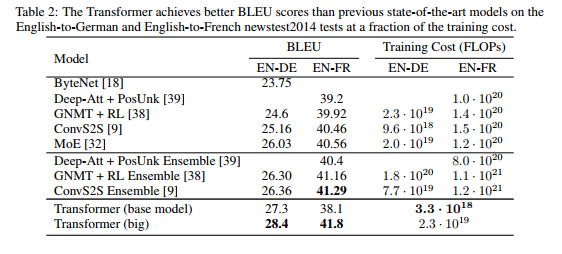

我们在这里编写的代码是基本模型的一个版本。 这里有系统完整训练的版本 ([Example Models](http://opennmt.net/Models-py/)).

通过上一节中的附加扩展，OpenNMT-py复制在EN-DE WMT上达到26.9。 在这里，我已将这些参数加载到我们的重新实现中。 

In [49]:
# !wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt
import sys
sys.path.append("../PyTorch_Learn_py")
from transformer import *

model, SRC, TGT = torch.load("../../data/英语-德语翻译/en-de-model.pt", map_location="cpu")

model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans) 

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 


### 4.7 注意力可视化

Encoder Layer 2


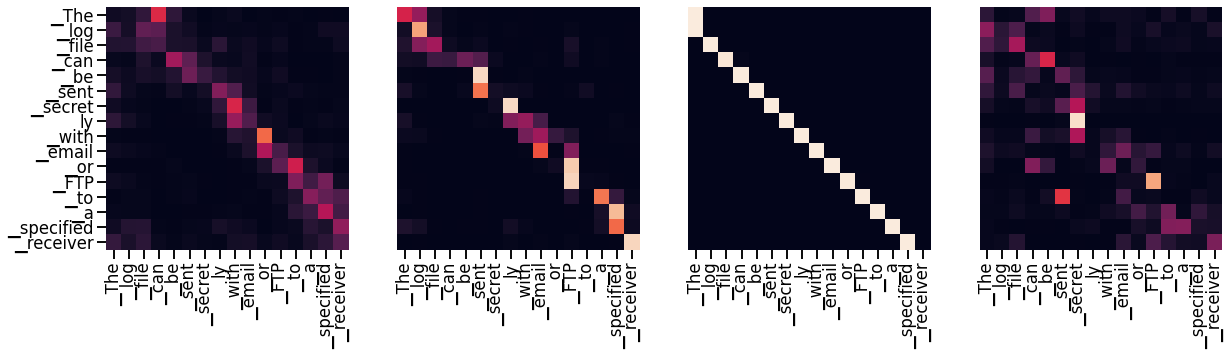

Encoder Layer 4


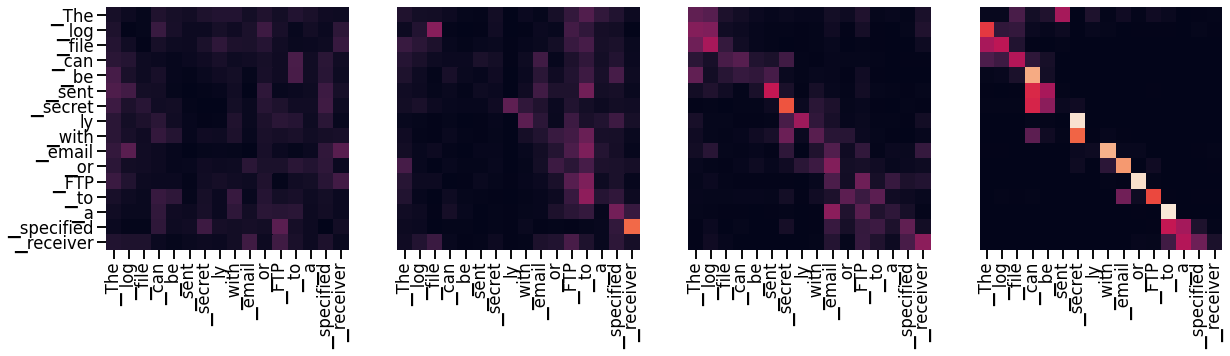

Encoder Layer 6


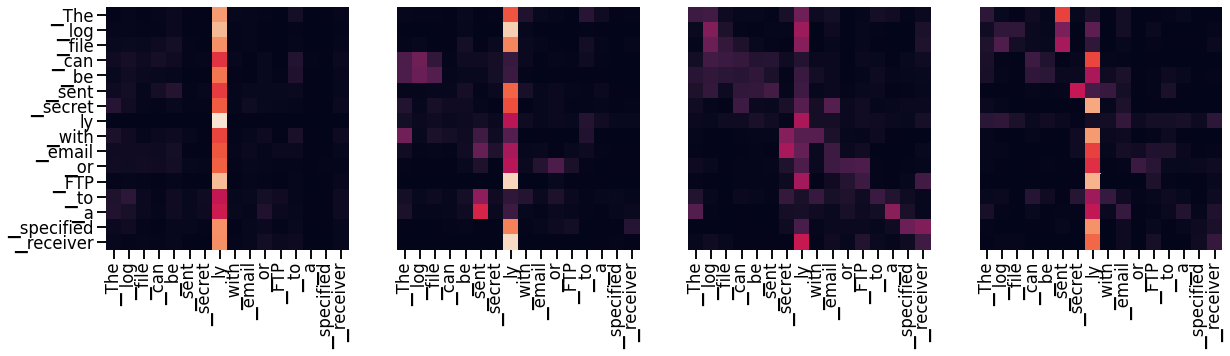

Decoder Self Layer 2


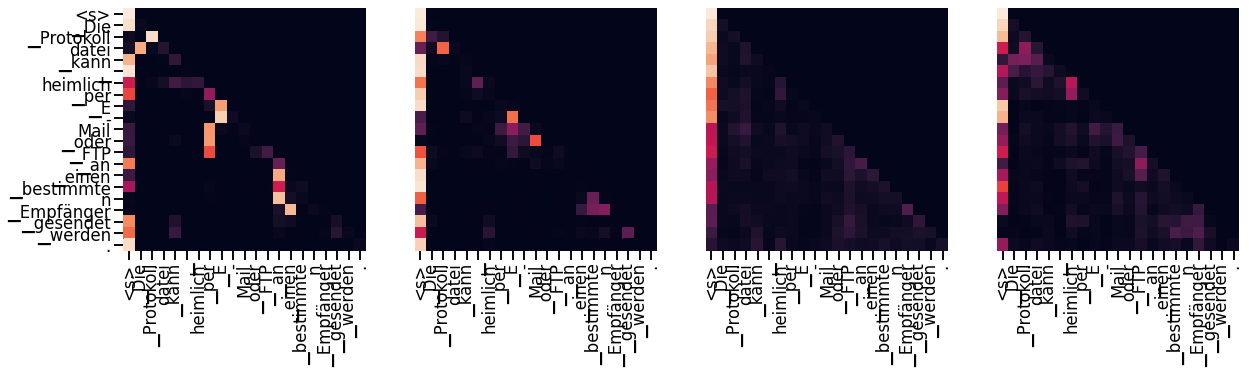

Decoder Self Layer 4


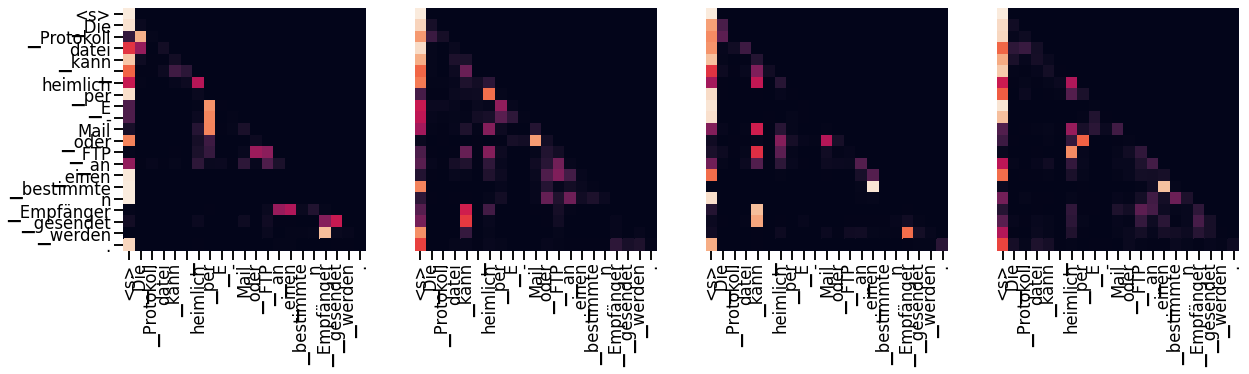

Decoder Self Layer 6


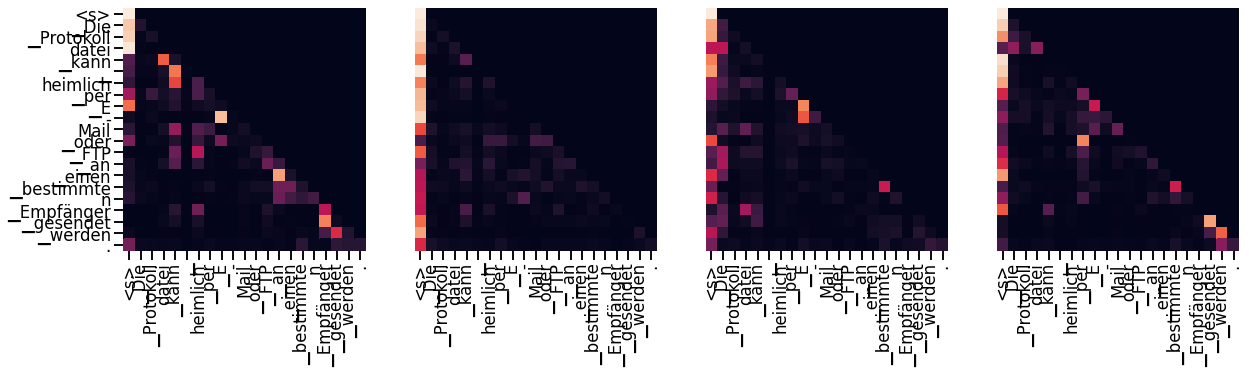

In [51]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                   xticklabels=x, square=True, yticklabels=y, 
                    vmin=0.0, vmax=1.0, cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h == 0 else [], ax=axs[h])
    plt.show()

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    print("Decoder Self Layer", layer + 1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h]
             .data[:len(tgt_sent), :len(tgt_sent)],
            tgt_sent, tgt_sent if h == 0 else [], ax=axs[h])
    plt.show()

## 5总结

在此时学习中，我首先深入理解了一下transformer模型，理解其中每个模块的运作流程与作用，并尝试用模块化的语言描述整个模型的执行流程，这个过程中写下的东西并不完全正确，存在一些存疑或者理解错误的地方；然后阅读transformer实现的源码，学习其思路与优秀的编码结构，然后尝试自己复现该模型；在顺着作者思路编写模型的过程中，加深了对模型的理解，包括一些模块的作用方式，如注意力算法为何能起到注意力的作用，通过理解参数维度及其意义对其有了更精准的理解，这个过程中的很多信息都是可以延伸到其他模型中的；对模型训练的整个流程有了更深入的理解；对模型图有了更深入的理解，其中的每一条线每一个框都是有具体含义的，都会在代码中体现。

一些傻傻的知识总结：
- 模型训练时传入的数据一般以批计算，一批数据中有多组数据（这里就是多组翻译句子），每组数据分为训练数据与目标数据，在传入模型前会将数据转换成句子向量，在经过嵌入层将句子中的词变成词向量，transformer还需要在这之后附加上位置信息，运算时相当于对多条记录同时并发运算。
- 一个模型从概念到应用分为：理解概念>构建模型>构建优化器>搭建训练方法>搭建模型应用方法>搭建结果处理方法（模型生成的是向量，需要转成需要的格式），此外还可以有一些其他内容
    - 搭建并发训练方法
- 模型中的一些优化项
    - dropout：在模型中每一层的训练结果中随机的清理向量的一部分，提高模型泛化能力
    - teacher forcing: 在模型训练时，为下一层输入时不使用上一层的结果，而是使用正确结果，从而提高学习速率
    - 正则化